# Wifi Sensor Networks for IoT

Program all the Pis 

Sniff all the wifis

Ingest all the data

Hack all the things

<img src="https://charlesreid1.com/w/images/0/02/HackDawg.jpg" width="300px" />

# Useful Links

[MongoDB Documentation - Python](https://docs.mongodb.com/getting-started/python/query/)

[PyMongo Documentation](https://api.mongodb.com/python/current/)

[PyMongo Query Examples](https://api.mongodb.com/python/current/examples/index.html)

# Research Questions

Here are a few research questions we may be interested in answering:
* How many unique devices did we see in each experiment? (How busy is this area?)
* How many unique access points did we see in each experiment? (How crowded are the airwaves?)
* What channels are the most crowded?
* What is the average duration for seeing a device?
* What is the distribution of signal strengths?
* What is the distribution of types of devices?
* How much data are clients using, and what is the distribution of traffic?

In [80]:
%matplotlib inline

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from pymongo import MongoClient

import re
import random
from pprint import pprint # Use pprint for printing out lists, one element per line

In [82]:
client = MongoClient('inspiring_boyd', 27017) # inspiring_boyd is the name of the MongoDB instance
db = client.wifi
client_collection = db.client_data
ap_collection = db.ap_data

# Simple Queries

Start with a simple query to match *every* MAC address that we've seen:

In [83]:
cursor = client_collection.find()
for j,doc in enumerate(cursor):
    print "Client MAC Address: %s"%(doc['mac'])
    if(j>10):
        break

Client MAC Address: 30:CD:A7:30:4E:B5
Client MAC Address: A8:BB:CF:20:81:70
Client MAC Address: D8:5B:2A:DC:84:ED
Client MAC Address: 1A:09:C2:1D:6F:D6
Client MAC Address: 6E:BC:2D:E4:57:B1
Client MAC Address: 84:7A:88:64:A3:FA
Client MAC Address: 30:CD:A7:30:4E:B5
Client MAC Address: 50:9E:A7:D9:ED:4B
Client MAC Address: 30:8C:FB:89:C6:43
Client MAC Address: 60:67:20:4D:1F:64
Client MAC Address: C0:EE:FB:DE:66:68
Client MAC Address: 30:CD:A7:30:4E:B5


Here is a query to match particular MAC addresses using a regular expression:

In [84]:
cursor = client_collection.find({'mac':{'$regex':'^AA'}}) # ^ means "start", so ^AA means "starts with AA"
for j,doc in enumerate( cursor ):
    print "Client MAC Address Starting With AA: %s"%(doc['mac'])
    if(j>10):
        break

Client MAC Address Starting With AA: AA:45:17:B6:11:C3
Client MAC Address Starting With AA: AA:23:33:FF:7B:F9
Client MAC Address Starting With AA: AA:F3:4E:64:FF:84
Client MAC Address Starting With AA: AA:9B:16:F6:DB:34
Client MAC Address Starting With AA: AA:9A:34:08:BD:1B
Client MAC Address Starting With AA: AA:F3:4E:64:FF:84
Client MAC Address Starting With AA: AA:C3:C3:D3:04:DA
Client MAC Address Starting With AA: AA:A9:72:49:6C:75
Client MAC Address Starting With AA: AA:2D:BE:83:28:94
Client MAC Address Starting With AA: AA:7F:C7:E1:CF:A2
Client MAC Address Starting With AA: AA:46:BF:D3:37:F9
Client MAC Address Starting With AA: AA:C3:C3:D3:04:DA


# Unique Devices

Unique devices can be identified using their MAC address, which is their digital fingerprint. 

To count all of the unique devices we saw in a given experiment, we can run a query to extract all MAC addresses for a given experiment, and add each MAC address to a set to create a unique list.

In [85]:
# This query extracts all MAC addresses 
# Needs to be adjusted to extract MAC addresses for one experiment
cursor = client_collection.find()

# Here's a short example:
s = set()
for j,doc in enumerate(cursor):
    s.add(doc['mac'])
    # Only print the first 10
    if(j>10):
        break

pprint(s)

set([u'1A:09:C2:1D:6F:D6',
     u'30:8C:FB:89:C6:43',
     u'30:CD:A7:30:4E:B5',
     u'50:9E:A7:D9:ED:4B',
     u'60:67:20:4D:1F:64',
     u'6E:BC:2D:E4:57:B1',
     u'84:7A:88:64:A3:FA',
     u'A8:BB:CF:20:81:70',
     u'C0:EE:FB:DE:66:68',
     u'D8:5B:2A:DC:84:ED'])


In [86]:
# Here's a longer example:
cursor = client_collection.find()

s = set()
for j,doc in enumerate(cursor):
    s.add(doc['mac'])

print len(s)

2035


# Unique Access Points

Unique access points can also be identified using their MAC addresses, so counting up the number of unique access points looks pretty much the same.

In [87]:
# This query extracts all MAC addresses 
# Needs to be adjusted to extract MAC addresses for one experiment
cursor = ap_collection.find()

s = set()
for j,doc in enumerate(cursor):
    s.add(doc['bssid'])

print len(s)

4261


# Channel Usage

To check how crowded channels are, we can extract a list of channels used by access points; this will be a list like `[6, 6, 11, 6, 1, 7, 4, 6, 8, 6]`. If we plot a histogram of this list, that will show us which channels are the most crowded.

In [108]:
cursor = ap_collection.find()

channels = [] # for non-unique items, use a list, not a set!

for j,doc in enumerate(cursor):
    channels.append(doc['channel'])

Seaborn (sns) is a module for making nice, pretty plots. By default, the plots don't look that great:

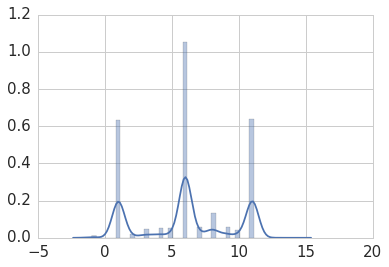

In [109]:
# This makes a distribution plot
sns.distplot(channels)
plt.show()

But with a little bit of magic, they start to look a lot better:

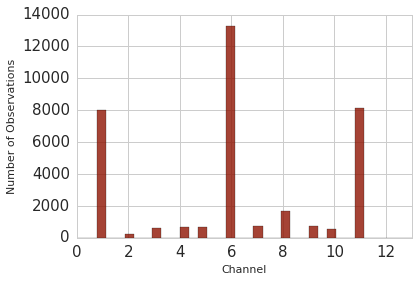

In [110]:
ax = sns.distplot(channels,
                  kde=False,
                  hist_kws={'alpha':0.8},
                  color=sns.xkcd_rgb['brick red'])

ax.set_xlim([0,13])
ax.set_xlabel('Channel')
ax.set_ylabel('Number of Observations')
plt.show()

# Average Duration of Seeing a Device

If we want to compute the average duration of seeing a wireless device (clients only, not access points), we should start with a list of unique clients. For each client, compute the duration by getting all timestamps associated with that device, and subtract the first timestamp from the last timestamp. Add each duration to a list, and then compute the average.

In [111]:
# Here is an example duration calculation for one client
# (we'll call our client Bilbo Baggins)

bilbo_baggins = '60:67:20:4D:1F:64'

cursor = client_collection.find({'mac': bilbo_baggins})

bilbo_timestamps = []
for j,doc in enumerate(cursor):
    bilbo_timestamps.append( doc['time'] )

print "Found %d matching timestamps"%(len(bilbo_timestamps))

Found 18 matching timestamps


As it turns out, MongoDB returns the data in correct datetime format, which means we can do algebra with the timestamps:

In [112]:
print type(bilbo_timestamps[0])

bilbo_timestamps.sort()
print "First seen: \t%s"%(bilbo_timestamps[0])
print "Last seen: \t%s"%(bilbo_timestamps[-1])
print "Duration: \t%s"%(bilbo_timestamps[-1] - bilbo_timestamps[0])

<type 'datetime.datetime'>
First seen: 	2017-04-13 16:00:26
Last seen: 	2017-04-13 17:58:27
Duration: 	1:58:01


# Distribution of Signal Strengths

We may want to examine the distribution of wireless signal strengths.

In [114]:
# This query extracts all MAC addresses 
# Needs to be adjusted to extract MAC addresses for one experiment
cursor = client_collection.find()

pwr = []
for j,doc in enumerate(cursor):
    pwr.append(doc['power'])

Once again, the data we extract from MongoDB has the correct type! (integer)

In [115]:
print type(pwr[0])

print len(pwr)

<type 'int'>
6003


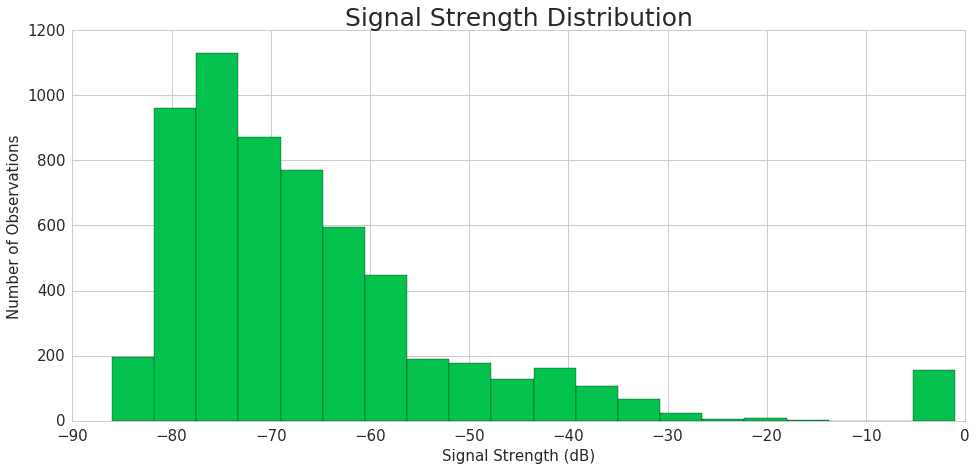

In [116]:
#client_cursor = client_collection.find({'host': host, 
#                                        'time': {"$gt":datetime.datetime(2017,4,24), 
#                                                 "$lt": datetime.datetime(2017,4,25)} })

plt.rc('axes',titlesize = 25)
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)

sns.set_style("whitegrid")

fig = plt.figure(figsize=(16,7))
ax = fig.add_subplot(111)
ax = sns.distplot(pwr,
                  kde=False,
                  bins=20,
                  hist_kws={'alpha':1},
                  color=sns.xkcd_rgb['shamrock green'])

ax.set_title('Signal Strength Distribution')
ax.set_xlabel('Signal Strength (dB)', fontsize = 15)
ax.set_ylabel('Number of Observations', fontsize = 15)
plt.show()

In [128]:
data = np.log((np.multiply(pwr,-1.0)))

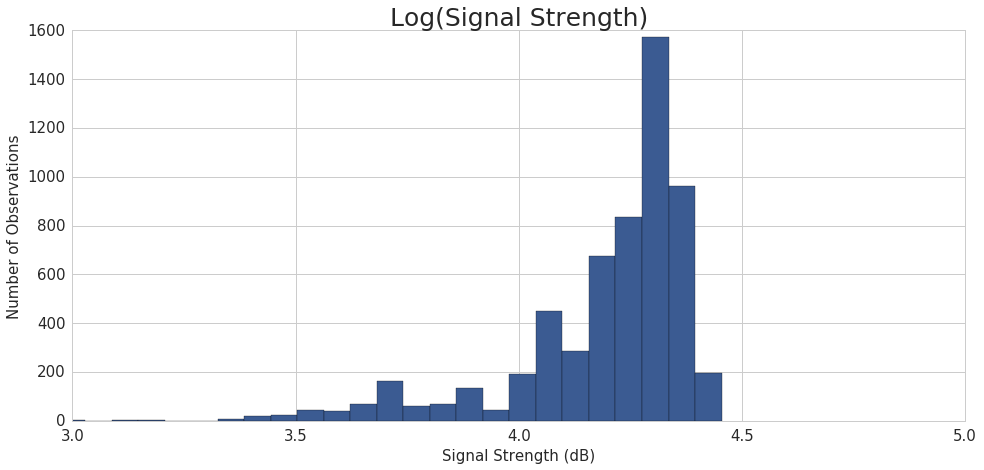

In [130]:
plt.rc('axes',titlesize = 25)
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)

sns.set_style("whitegrid")

fig = plt.figure(figsize=(16,7))
ax = fig.add_subplot(111)
ax = sns.distplot(data,
                  kde=False,
                  bins=75,
                  hist_kws={'alpha':1},
                  color=sns.xkcd_rgb['denim blue'])

ax.set_title('Log(Signal Strength)')
ax.set_xlabel('Signal Strength (dB)', fontsize = 15)
ax.set_ylabel('Number of Observations', fontsize = 15)

ax.set_xlim([3.0, 5.0])
plt.show()

If you take the log of the signal strength distribution, 

$$
SS \sim \frac{1}{r^2}
$$

$$
\log(SS) \sim -2 \log(r)
$$
So if slope of -2, then power of $1/r^2$.

# Grouping Experiments

To group experiment data together, we can find records with `host` equal to `thing1` or `thing2`. We can narrow things down further by using date and time criteria.

In [25]:
# This query extracts all wifi network names seen by thing1.
cursor = ap_collection.find({'host': 'thing1'})

essids = set()
for j,doc in enumerate(cursor):
    essids.add(doc['essid'])

print("Saw %d networks:"%(len(essids)))
pprint(essids)

Saw 1839 networks:
set([u'',
     u'"305 for phone. "',
     u'"City Paws Guest "',
     u'"Dial-up "',
     u'"Marlpy "',
     u'"Spec Ops O "',
     u'"WhateversClever "',
     u'#spacecastlez',
     u'(C(Jf6HAI3fKv)Hc',
     u'-HOME-',
     u'-_-',
     u"....\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\xDD.\\x00....\\x00\\x00\\xFF.\\xDD.\\x00....\\x00.\\x00@\\x00\\xDD'\\x00P\\xF2..J\\x00...D\\x00",
     u'001',
     u'0024b100000220d2',
     u'0A344ABB',
     u'0A9988AN',
     u'1-900-Mix-A-Lot',
     u'10000ft',
     u'1111 Engineering',
     u'1111net_1',
     u'1111net_2',
     u'1111net_3',
     u'1111net_4',
     u'1111net_5',
     u'1111net_6',
     u'1111net_7',
     u'1111net_8',
     u'1111net_9',
     u'11thAveInn',
     u'1221 1st Ave 307',
     u'12th Ave Rental',
     u'1373Arlington',
     u'1373Arlington-guest',
     u'1415',
     u'158 18th Ave Hello Neighbor!',
     u'1915',
     u'1EnergyCorp',
     u'1Energ

In [26]:
# Same query, but for thing2
cursor = ap_collection.find({'host': 'thing2'})

essids = set()
for j,doc in enumerate(cursor):
    essids.add(doc['essid'])

print("Saw %d networks:"%(len(essids)))
pprint(essids)

Saw 361 networks:
set([u'',
     u'306',
     u'358_GUEST',
     u'5ECUR3w3p5TOR3',
     u'8MKODPLI',
     u'AG007',
     u'ASUS_2.4_Mo',
     u'ASUSofSpades2',
     u'Alejandro',
     u'Alias',
     u'Apollonails',
     u'Apollonails-guest',
     u'AppleNet',
     u'Auggie',
     u'B-TAPMYBOX_2.4',
     u'BAJR',
     u'BKJ-Home',
     u'Backfire',
     u'BeOurGuest',
     u'Bill Wi The Science Fi',
     u'Blumpkinet',
     u'Bomquisha',
     u'BonerJams02',
     u"Brittin's Guest Network",
     u"Brittin's Wi-Fi Network",
     u'BuckyBadger',
     u'Byrdhouse',
     u'CBCI-806D-2.4',
     u'CBCI-EC1E-2.4',
     u'CalebRules',
     u'Canterbury',
     u"Cara's Wi-Fi Network",
     u'CarlosM',
     u'CasaBarlita',
     u'CasaDeCurry',
     u'Cascadelink Free Wifi',
     u'Cascadelink407_2.4G',
     u'CenturyLink0199',
     u'CenturyLink0297',
     u'CenturyLink074a',
     u'CenturyLink0921',
     u'CenturyLink1543',
     u'CenturyLink1913',
     u'CenturyLink1951',
     u'CenturyLink198

# Extracting Experiment Dates/Times

We can extract timestamps from all of our wifi experiments and figure out how many experiments we have and what their date and time ranges are. To do this, we will create two sets of timestamps: one for thing1 and one for thing2. We can use either the `ap_data` or the `client_data` table. The `client_data` table is about 5 times smaller, so let's go with that one.

In [27]:
hosts = ['thing1','thing2']
timestamp_sets = []

for host in hosts:
    cursor = client_collection.find({'host': host})
    
    times = set()
    for j,doc in enumerate(cursor):
        times.add(doc['time'])
    
    timestamp_sets.append(times)
    print("Host %s: found %d timestamps"%(host,len(times)))


Host thing1: found 3682 timestamps
Host thing2: found 421 timestamps


Now we will plot the timestamps on the x axis, and plot a 1 on the y axis if it is an experiment with thing1 and a 2 on the y axis if it is an experiment with thing2.

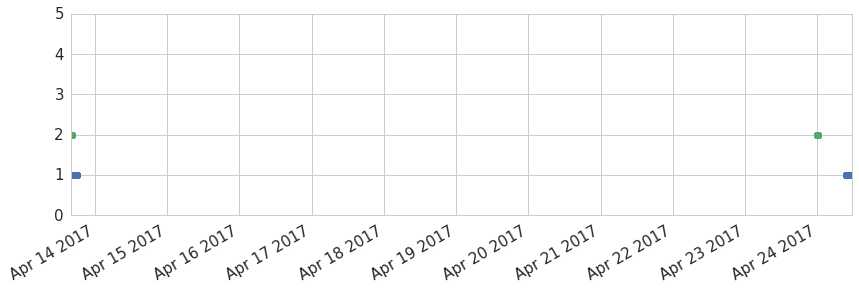

In [36]:
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(111)

for i,host in enumerate(hosts):

    xx = list(timestamp_sets[i])
    yy = [i+1,]*len(xx)

    ax.plot(xx,yy,'o')
    
ax.set_ylim([0,5])
fig.autofmt_xdate()

Thing1 experiments:
* First experiment was on or around April 14th, so if we want to extract only data from the first experiment with thing1, we can search for all data between April 13 and April 15 where the "host" field matches "thing1".
* Second experiment was on or around April 24th, so if we want to extract data from the second experiment we can look for data between April 23 and April 25 where the host is thing1.

Thing2 experiments:
* First experiment was on or around April 14th
* Second experiment was on or around April 24th.
